# Replay demonstration

In [1]:
%reset -f
%matplotlib inline
%load_ext autoreload
%autoreload 1
%aimport replay.plot
%aimport replay.analysis
from copy import deepcopy as copy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from aux import sgmd
from disp import set_font_size, set_n_x_ticks, set_n_y_ticks
from replay import smln, analysis, plot

cc = np.concatenate


# model
M_PARAMS = {
    # Exc. PC membrane
    'T_M_PC': 0.05, 'E_L_PC': -0.068, 'V_TH_PC': -0.036, 'V_R_PC': -0.068, 'T_R_PC': 0.008,
    
    # Exc. PC architecture
    'N_PC': 3000,
    'W_PC_PC': .026, 'L_PC_PC': 0.053, 'W_MIN_PC_PC': 0.001,
    
    # "Place-tuned" PC inputs
    'R_MAX': 20, 'L_PL': .15,
    'W_PC_PL': 0.02, 'S_PC_PL': 0,
    
    # Inh. membrane
    'T_M_INH': 0.005, 'E_L_INH': -0.06, 'V_TH_INH': -0.05, 'V_R_INH': -0.06, 'T_R_INH': 0.002,
    
    # Inh. architecture
    'N_INH': 300,
    'W_INH_PC': 0.003, 'W_PC_INH': 0.0002,
    
    # gating inputs
    'W_PC_G': 0.008216, 'S_PC_G': 0,
    
    # synaptic reversal potentials & time constants
    'E_E': 0, 'E_I': -0.08, 'T_E': 0.002, 'T_I': 0.002, 
    
    # Gating input firing rates for traj and replay epochs
    'R_G': 125, 
    
    # potentiation
    'SGM_MAX': 2, 'B_SGM': 1, 'R_SGM': 10
}

# simulation
S_PARAMS = {
    "RNG_SEED": None,
    "DT": 0.0005, "BOX_H": 2, "BOX_W": 2, "X_TRG": 1, "Y_TRG": -0.75,
    
    'SPD': 0.2, 'TRJ': [(-1, .75), (0, .75), (0, -.75), (1, -.75)],
    
    'TRG': [
        {'T': 0.5, 'A': 0.00, 'R': 0.3, 'D': 0.002, 'X': 1, 'Y': -0.75},
    ],
    
    "schedule": {"D_SMLN": 3},
}

## Example sqexp place field

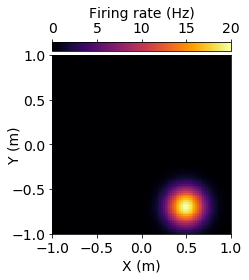

In [2]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

PF_X, PF_Y = (.5, -.7)
X_LIM = (-1, 1)
Y_LIM = (-1, 1)

fig, ax = plt.subplots(1, 1, figsize=(4, 4), tight_layout=True)

x_ = np.linspace(*X_LIM, 100)
y_ = np.linspace(*Y_LIM, 100)

x, y = np.meshgrid(x_, y_)
dx = x - PF_X
dy = y - PF_Y
r = M_PARAMS['R_MAX'] * np.exp(-.5*(dx**2 + dy**2)/M_PARAMS['L_PL']**2)

im = ax.imshow(r, origin='lower', vmin=0, vmax=M_PARAMS['R_MAX'], cmap='inferno', extent=[-1, 1, -1, 1])

set_n_x_ticks(ax, 5)
set_n_y_ticks(ax, 5)
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)', labelpad=-10)

set_font_size(ax, 14)

divider = make_axes_locatable(ax)
c_ax = divider.append_axes('top', '5%', pad=0.05)
c_ax.yaxis.set_visible(False)

cb = fig.colorbar(im, cax=c_ax, ticks=np.linspace(0, M_PARAMS['R_MAX'], 5), orientation='horizontal')

c_ax.set_xlabel('Firing rate (Hz)')
c_ax.xaxis.tick_top()
c_ax.xaxis.set_label_position('top')

set_font_size(c_ax, 14)

## Show firing rate and $\sigma$ vs dist from place field

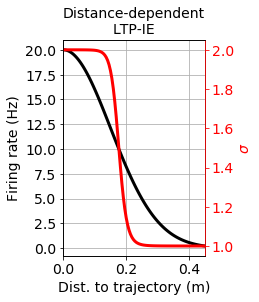

In [3]:
d = np.linspace(0, 3*M_PARAMS['L_PL'], 100)
r = M_PARAMS['R_MAX'] * np.exp(-.5*(d**2)/M_PARAMS['L_PL']**2)
sgm = 1 + (M_PARAMS['SGM_MAX'] - 1) * sgmd(M_PARAMS['B_SGM']*(r - M_PARAMS['R_SGM']))

fig, ax = plt.subplots(1, 1, figsize=(3.7, 4.3), tight_layout=True)
ax.plot(d, r, color='k', lw=3)

ax.set_xlabel('Dist. to trajectory (m)')
ax.set_ylabel('Firing rate (Hz)')
ax.set_title('Distance-dependent\nLTP-IE')

ax_twin = ax.twinx()
ax_twin.plot(d, sgm, color='r', lw=3)
ax_twin.spines['right'].set_color('r')
ax_twin.tick_params(axis='y', colors='r')

ax.set_xlim(d[0], d[-1])

ax_twin.set_ylabel('$\sigma$', color='r')

set_font_size(ax, 14)
set_font_size(ax_twin, 14)

ax.grid()

## Recurrent connectivity profile

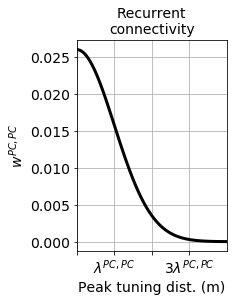

In [17]:
d = np.linspace(0, 4*M_PARAMS['L_PC_PC'], 100)
w = M_PARAMS['W_PC_PC']*np.exp(-.5*(d**2)/(M_PARAMS['L_PC_PC']**2))

fig, ax = plt.subplots(1, 1, figsize=(3.4, 4.3), tight_layout=True)

ax.plot(d, w, color='k', lw=3)

ax.set_xlim(d[0], d[-1])
ax.set_xticks([0, M_PARAMS['L_PC_PC'], 2*M_PARAMS['L_PC_PC'], 3*M_PARAMS['L_PC_PC']])
ax.set_xticklabels(['', r'$\lambda^{PC,PC}$', '', r'$3\lambda^{PC,PC}$'])
ax.set_xlabel('Peak tuning dist. (m)')
ax.set_ylabel('$w^{PC,PC}$')
ax.set_title('Recurrent\nconnectivity')

ax.grid()

set_font_size(ax, 14)

## Functional replay with inhibition

Triggered replay is slower. Spontaneous replay beginning in middle of LTP-IE-tagged path spreads in only one direction due to competition. Inhibition is recruited in oscillatory rather than constant pattern, suggestive of SWRs (although frequency is not correct).

In [5]:
m_params = copy(M_PARAMS)
s_params = copy(S_PARAMS)

s_params['RNG_SEED'] = 12

print('Running smln...')
rslt = smln.run(m_params, s_params)
print('Smln complete.')

Running smln...
Smln complete.


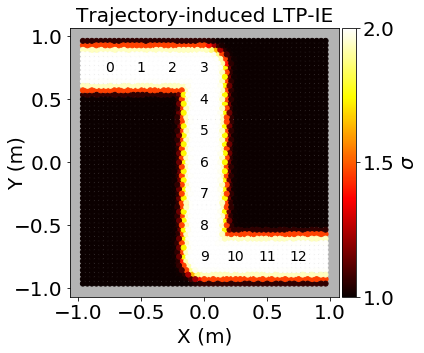

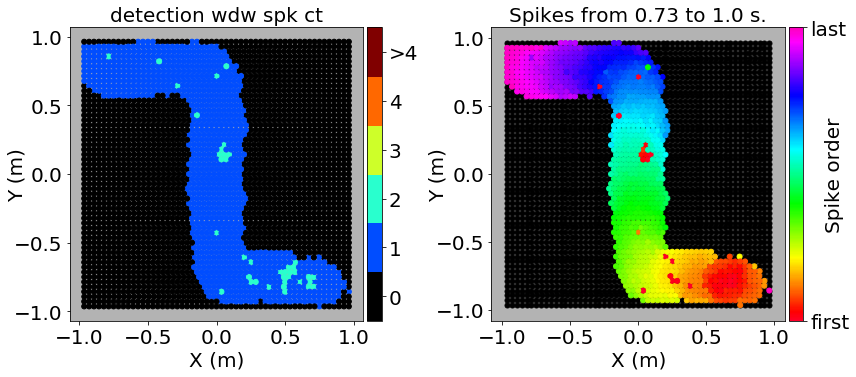

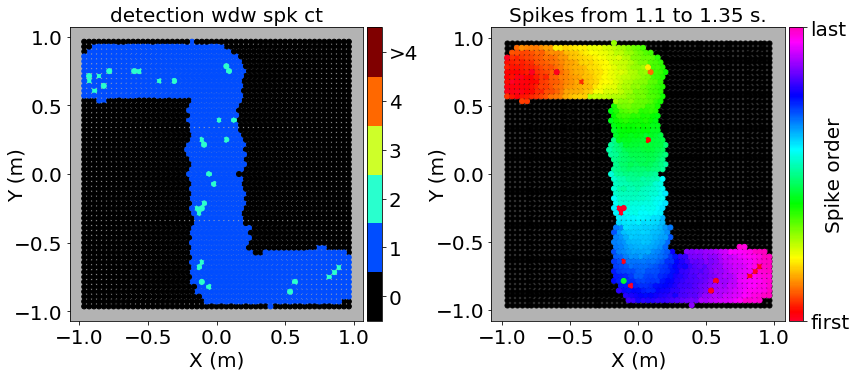

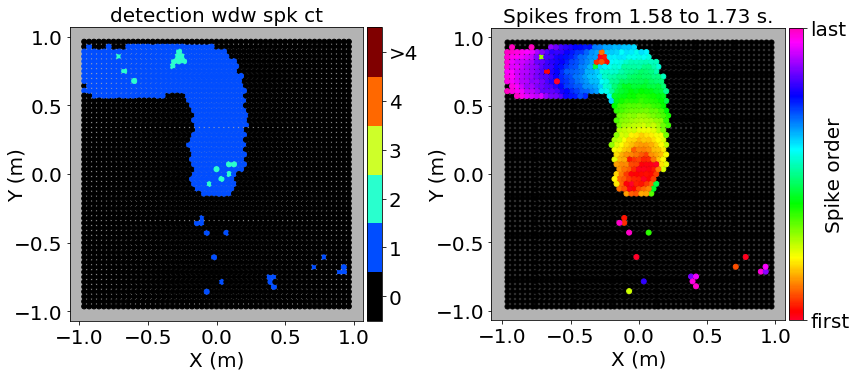

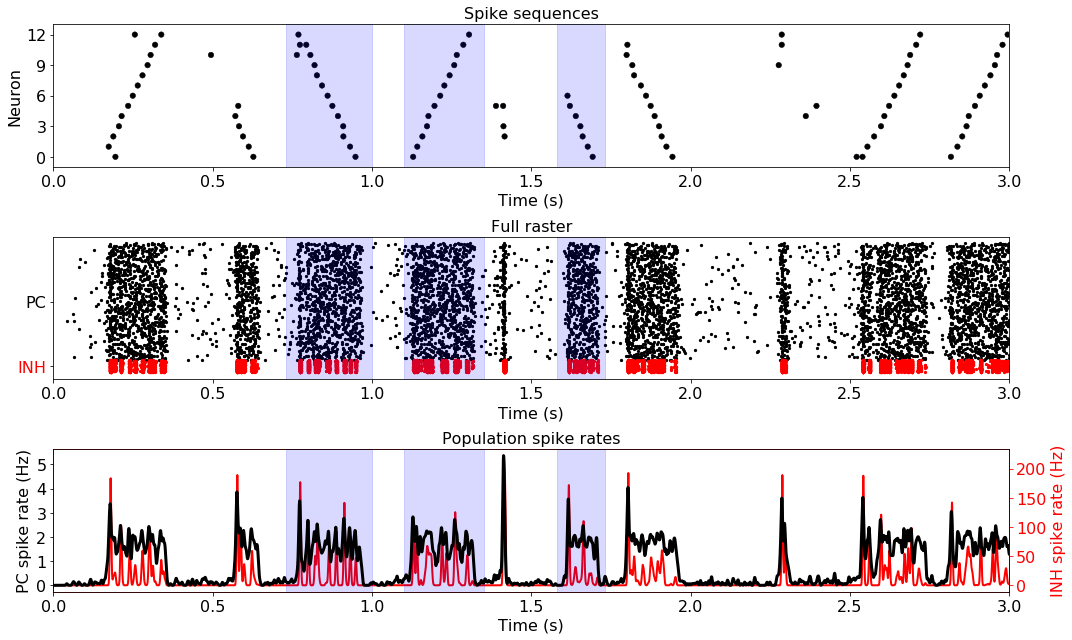

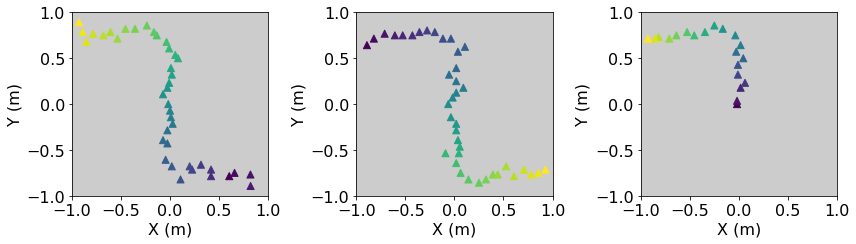

In [6]:
from replay import plot

# make plots
XYS_RASTER = [
    (-.75, .75), (-.5, .75), (-.25, .75), (0, .75),
    (0, .5), (0, .25), (0, 0), (0, -.25), (0, -.5),
    (0, -.75), (.25, -.75), (.5, -.75), (.75, -.75)
]
EPOCHS = [(.73, 1.), (1.1, 1.35), (1.58, 1.73)]

## potentiation profile
ax, c_ax = plot.ltp_ie_profile(rslt)

## add PC labels
for ctr, (x, y) in enumerate(XYS_RASTER):
    ax.text(x, y, str(ctr), fontsize=14, horizontalalignment='center', verticalalignment='center')

## selected replay epoch spike sequences
for epoch in EPOCHS:
    fig, axs = plot.spike_seq(rslt, epoch=epoch)

## raster for selected PCs
fig, axs = plot.raster_with_pc_inh(
    rslt,
    XYS_RASTER,
    colors=np.zeros(len(XYS_RASTER)),
    cmap='inferno',
    nearest=1,
    epoch=(0, 3),
    trg_plt=[],
    y_lim=(-1, 13),
    y_ticks=[0, 3, 6, 9, 12],
    smoothness=4)

## shade selected replay epochs
for epoch in EPOCHS:
    axs[0].axvspan(*epoch, color='b', alpha=0.15)
    axs[1].axvspan(*epoch, color='b', alpha=0.15)
    axs[2].axvspan(*epoch, color='b', alpha=0.15)
    
## plot decoded trajectories during replay epochs
axs = plt.subplots(1, len(EPOCHS), figsize=(len(EPOCHS)*4, 3.5), tight_layout=True, squeeze=False)[1][0]
for epoch, ax in zip(EPOCHS, axs):
    t, xy = analysis.decode_trj(rslt, epoch[0], epoch[1], .005, min_spks_wdw=10)
    plot.decoded_trj(ax, rslt, t, xy);

## Example with brief bidirectional event

In [7]:
m_params = copy(M_PARAMS)
s_params = copy(S_PARAMS)

s_params['RNG_SEED'] = 2

print('Running smln...')
rslt = smln.run(m_params, s_params)
print('Smln complete.')

Running smln...
Smln complete.


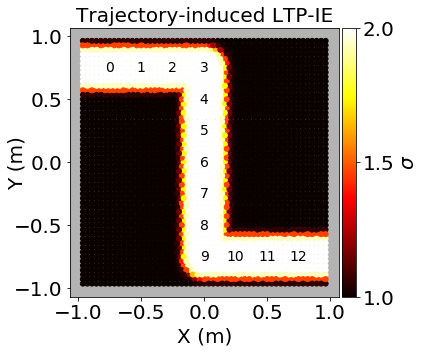

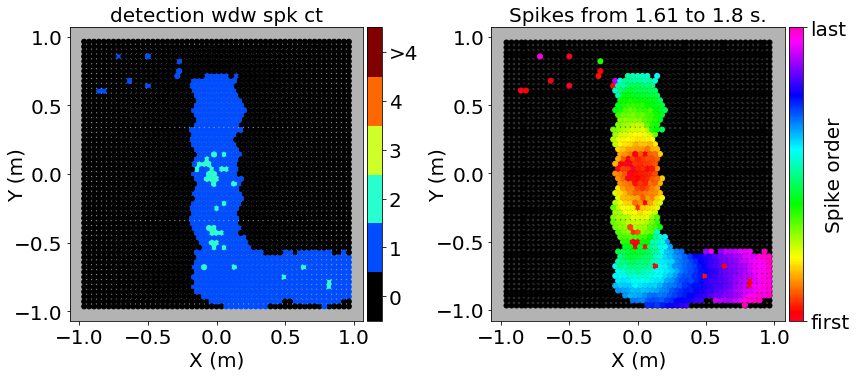

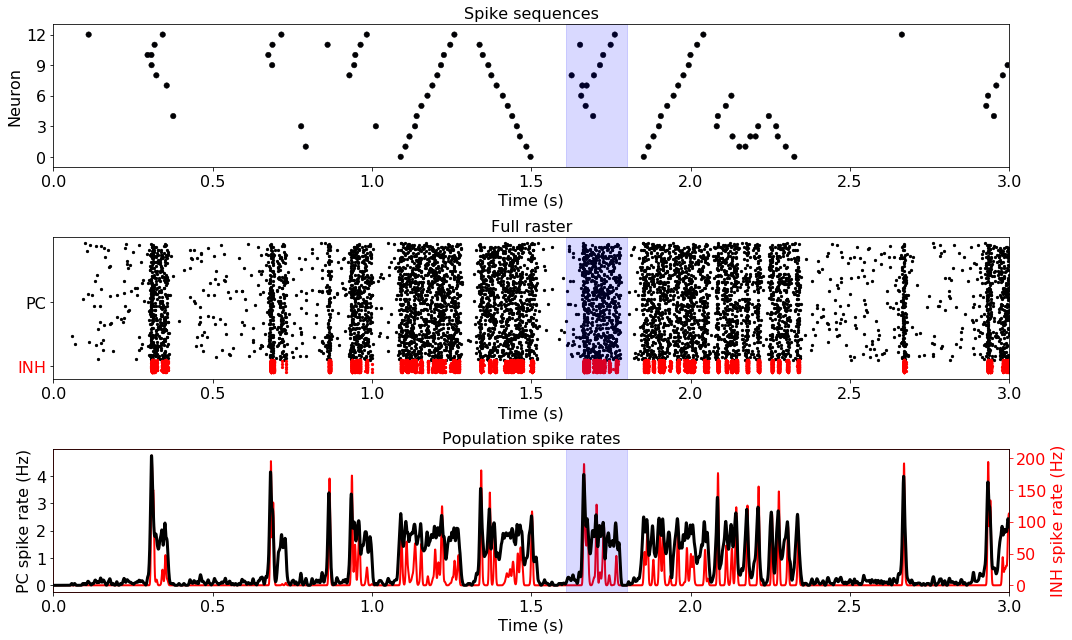

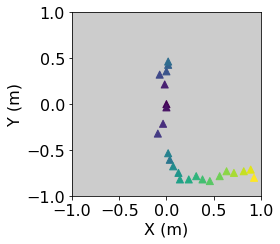

In [8]:
from replay import plot

# make plots
XYS_RASTER = [
    (-.75, .75), (-.5, .75), (-.25, .75), (0, .75),
    (0, .5), (0, .25), (0, 0), (0, -.25), (0, -.5),
    (0, -.75), (.25, -.75), (.5, -.75), (.75, -.75)
]
EPOCHS = [(1.61, 1.8)]

## potentiation profile
ax, c_ax = plot.ltp_ie_profile(rslt)

## add PC labels
for ctr, (x, y) in enumerate(XYS_RASTER):
    ax.text(x, y, str(ctr), fontsize=14, horizontalalignment='center', verticalalignment='center')

## selected replay epoch spike sequences
for epoch in EPOCHS:
    fig, axs = plot.spike_seq(rslt, epoch=epoch)

## raster for selected PCs
fig, axs = plot.raster_with_pc_inh(
    rslt,
    XYS_RASTER,
    colors=np.zeros(len(XYS_RASTER)),
    cmap='inferno',
    nearest=1,
    epoch=(0, 3),
    trg_plt=[],
    y_lim=(-1, 13),
    y_ticks=[0, 3, 6, 9, 12],
    smoothness=4)

## shade selected replay epochs
for epoch in EPOCHS:
    axs[0].axvspan(*epoch, color='b', alpha=0.15)
    axs[1].axvspan(*epoch, color='b', alpha=0.15)
    axs[2].axvspan(*epoch, color='b', alpha=0.15)
    
## plot decoded trajectories during replay epochs
axs = plt.subplots(1, len(EPOCHS), figsize=(len(EPOCHS)*4, 3.5), tight_layout=True, squeeze=False)[1][0]
for epoch, ax in zip(EPOCHS, axs):
    t, xy = analysis.decode_trj(rslt, epoch[0], epoch[1], .005, min_spks_wdw=10)
    plot.decoded_trj(ax, rslt, t, xy);

## Alternate trajectory

In [9]:
m_params = copy(M_PARAMS)
s_params = copy(S_PARAMS)

s_params['RNG_SEED'] = 1
s_params['TRJ'] = [(.75, -1), (.75, 0), (-.75, 0), (-.75, 1)]

print('Running smln...')
rslt = smln.run(m_params, s_params)
print('Smln complete.')

Running smln...
Smln complete.


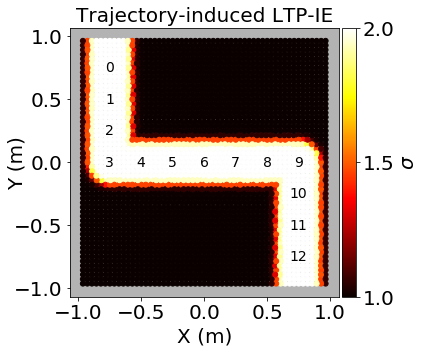

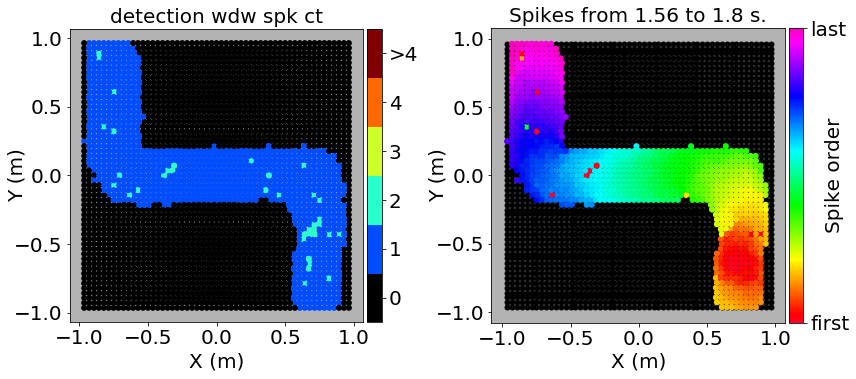

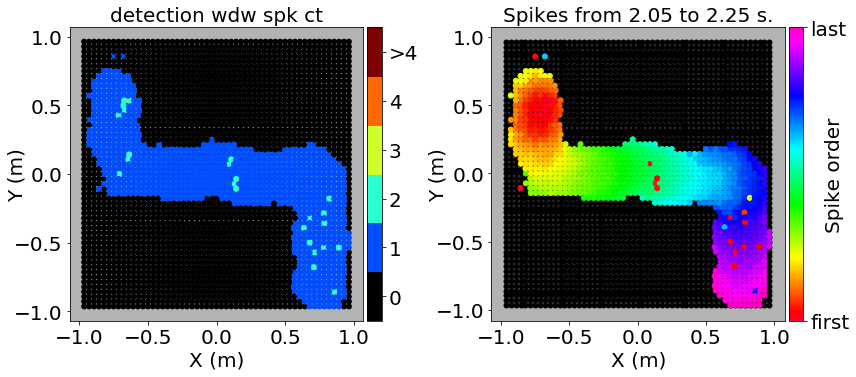

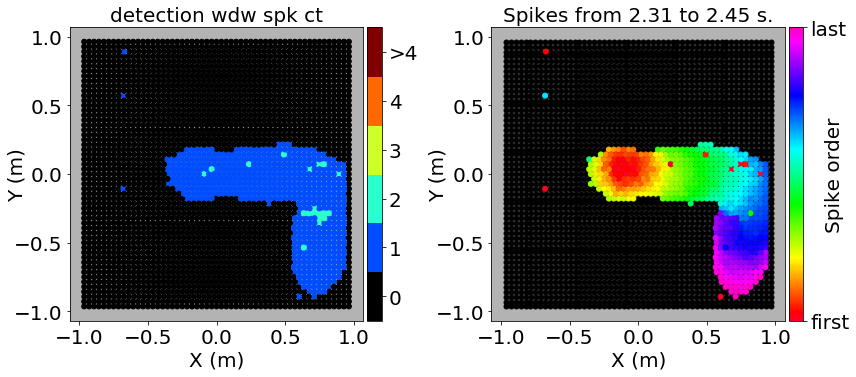

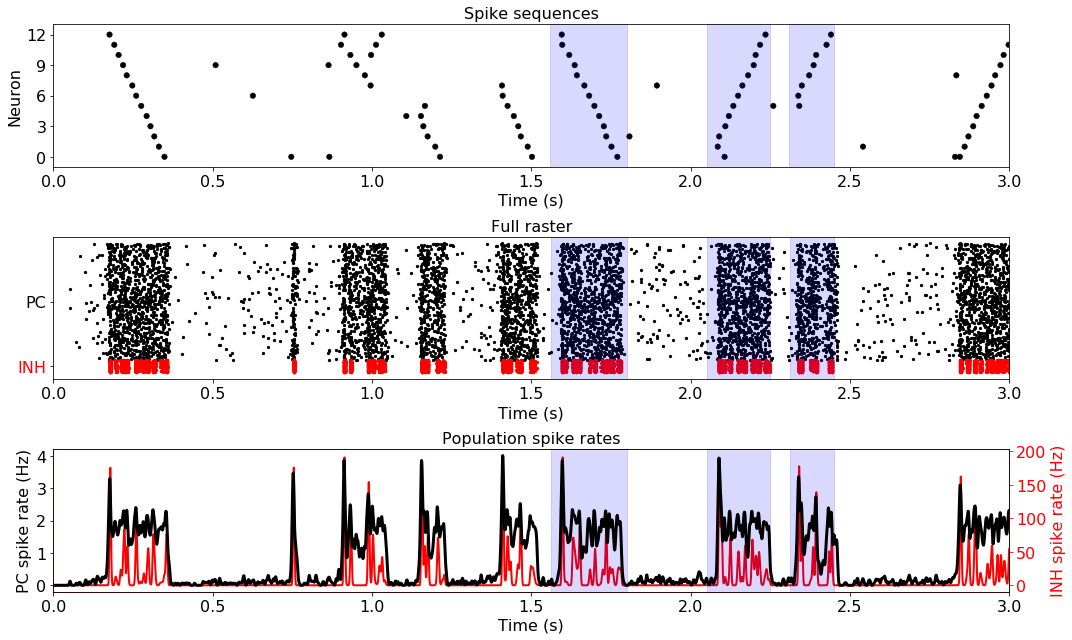

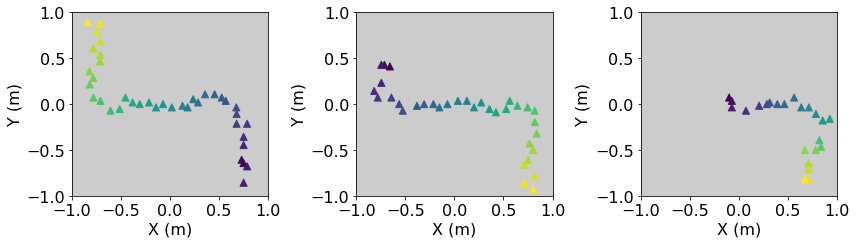

In [10]:
from replay import plot

# make plots
XYS_RASTER = [
    (-.75, .75), (-.75, .5), (-.75, .25), (-.75, 0),
    (-.5, 0), (-.25, 0), (0, 0), (.25, 0), (.5, 0),
    (.75, 0), (.75, -.25), (.75, -.5), (.75, -.75)
]
EPOCHS = [(1.56, 1.8), (2.05, 2.25), (2.31, 2.45)]

## potentiation profile
ax, c_ax = plot.ltp_ie_profile(rslt)

## add PC labels
for ctr, (x, y) in enumerate(XYS_RASTER):
    ax.text(x, y, str(ctr), fontsize=14, horizontalalignment='center', verticalalignment='center')

## selected replay epoch spike sequences
for epoch in EPOCHS:
    fig, axs = plot.spike_seq(rslt, epoch=epoch)

## raster for selected PCs
fig, axs = plot.raster_with_pc_inh(
    rslt,
    XYS_RASTER,
    colors=np.zeros(len(XYS_RASTER)),
    cmap='inferno',
    nearest=1,
    epoch=(0, 3),
    trg_plt=[],
    y_lim=(-1, 13),
    y_ticks=[0, 3, 6, 9, 12],
    smoothness=4)

## shade selected replay epochs
for epoch in EPOCHS:
    axs[0].axvspan(*epoch, color='b', alpha=0.15)
    axs[1].axvspan(*epoch, color='b', alpha=0.15)
    axs[2].axvspan(*epoch, color='b', alpha=0.15)
    
## plot decoded trajectories during replay epochs
axs = plt.subplots(1, len(EPOCHS), figsize=(len(EPOCHS)*4, 3.5), tight_layout=True, squeeze=False)[1][0]
for epoch, ax in zip(EPOCHS, axs):
    t, xy = analysis.decode_trj(rslt, epoch[0], epoch[1], .005, min_spks_wdw=10)
    plot.decoded_trj(ax, rslt, t, xy);

## Replay with stronger recurrent excitation

In [11]:
m_params = copy(M_PARAMS)
m_params['W_PC_PC'] = .029

s_params = copy(S_PARAMS)
s_params['RNG_SEED'] = 0
s_params['TRJ'] = [(-1, .75), (0, .75), (0, -.75), (1, -.75)]

print('Running smln...')
rslt = smln.run(m_params, s_params)
print('Smln complete.')

Running smln...
Smln complete.


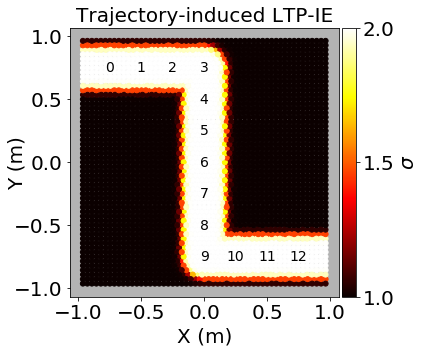

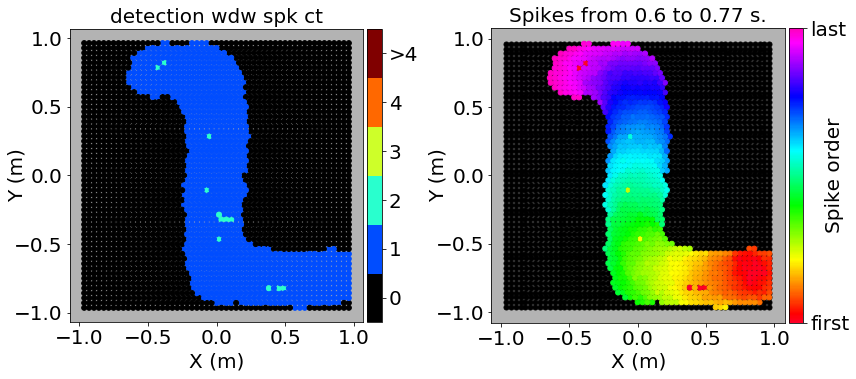

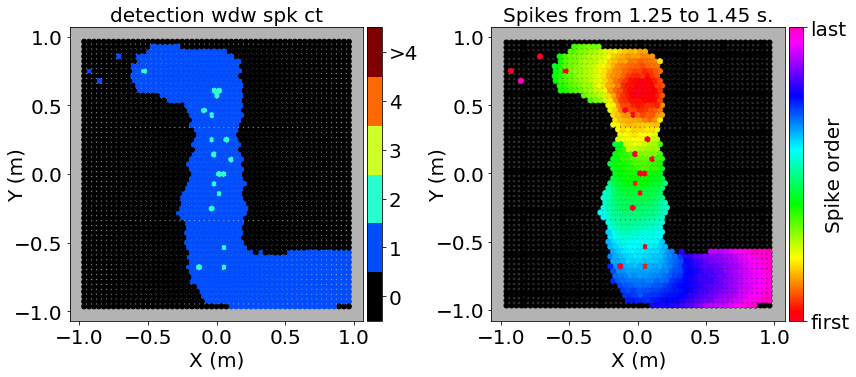

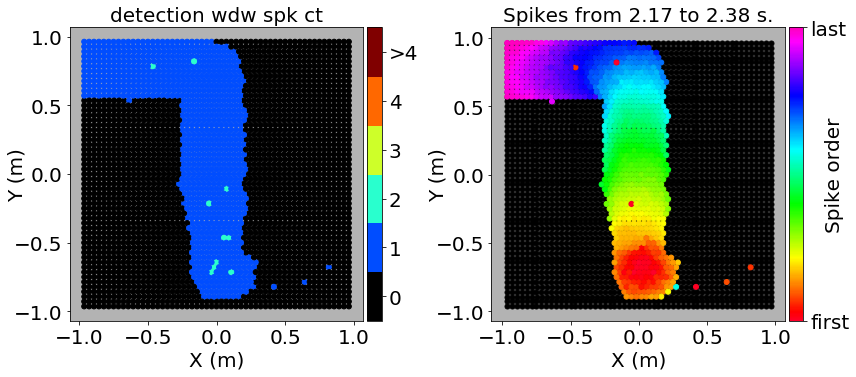

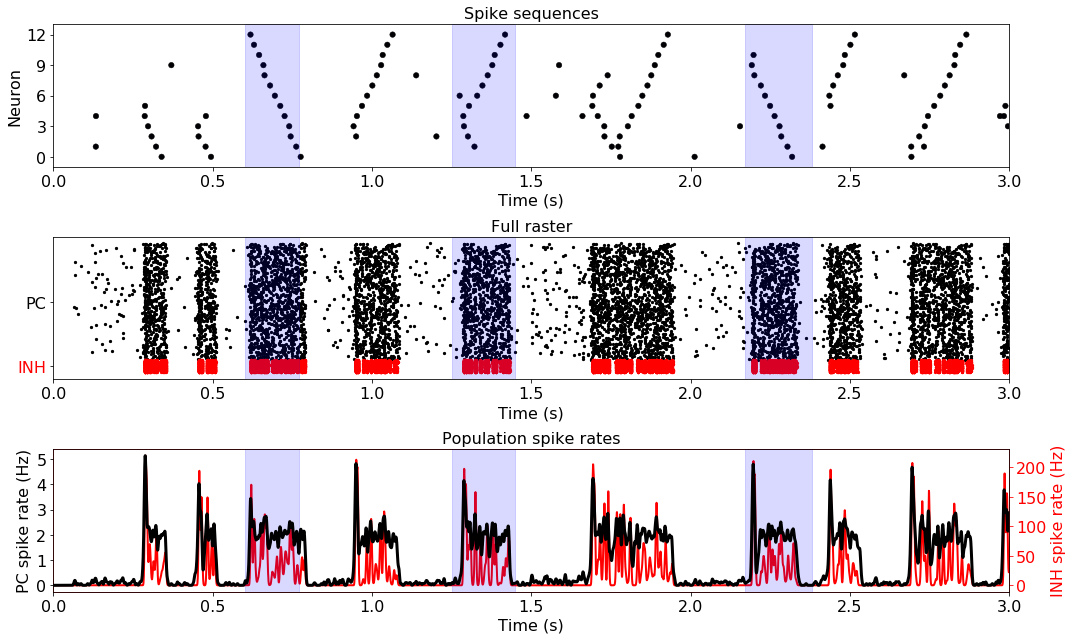

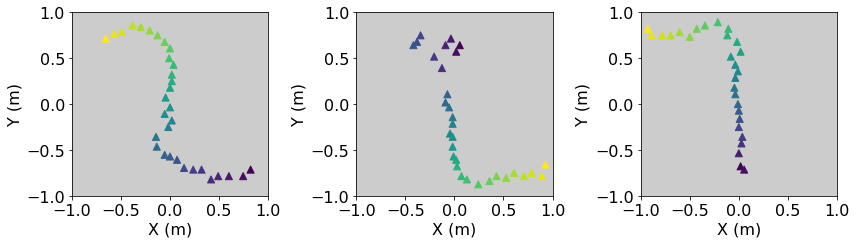

In [12]:
from replay import plot

# make plots
XYS_RASTER = [
    (-.75, .75), (-.5, .75), (-.25, .75), (0, .75),
    (0, .5), (0, .25), (0, 0), (0, -.25), (0, -.5),
    (0, -.75), (.25, -.75), (.5, -.75), (.75, -.75)
]
EPOCHS = [(.6, .77), (1.25, 1.45), (2.17, 2.38)]

## potentiation profile
ax, c_ax = plot.ltp_ie_profile(rslt)

## add PC labels
for ctr, (x, y) in enumerate(XYS_RASTER):
    ax.text(x, y, str(ctr), fontsize=14, horizontalalignment='center', verticalalignment='center')

## selected replay epoch spike sequences
for epoch in EPOCHS:
    fig, axs = plot.spike_seq(rslt, epoch=epoch)

## raster for selected PCs
fig, axs = plot.raster_with_pc_inh(
    rslt,
    XYS_RASTER,
    colors=np.zeros(len(XYS_RASTER)),
    cmap='inferno',
    nearest=1,
    epoch=(0, 3),
    trg_plt=[],
    y_lim=(-1, 13),
    y_ticks=[0, 3, 6, 9, 12],
    smoothness=4)

## shade selected replay epochs
for epoch in EPOCHS:
    axs[0].axvspan(*epoch, color='b', alpha=0.15)
    axs[1].axvspan(*epoch, color='b', alpha=0.15)
    axs[2].axvspan(*epoch, color='b', alpha=0.15)
    
## plot decoded trajectories during replay epochs
axs = plt.subplots(1, len(EPOCHS), figsize=(len(EPOCHS)*4, 3.5), tight_layout=True, squeeze=False)[1][0]
for epoch, ax in zip(EPOCHS, axs):
    t, xy = analysis.decode_trj(rslt, epoch[0], epoch[1], .005, min_spks_wdw=10)
    plot.decoded_trj(ax, rslt, t, xy);

## Functional replay without inhibition

Replay occurs when triggered at one end and is rather fast. When spontaneous replay occurs starting from the middle, it spreads in both directions.

## Another functional replay example without inhibition

In [13]:
m_params = copy(M_PARAMS)
m_params['W_INH_PC'] = 0
m_params['W_PC_PC'] = 0.023

s_params = copy(S_PARAMS)
s_params['RNG_SEED'] = 6
s_params['TRJ'] = [(-1, .75), (0, .75), (0, -.75), (1, -.75)]

print('Running smln...')
rslt = smln.run(m_params, s_params)
print('Smln complete.')

Running smln...
Smln complete.


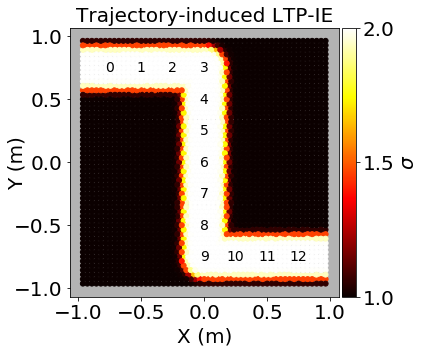

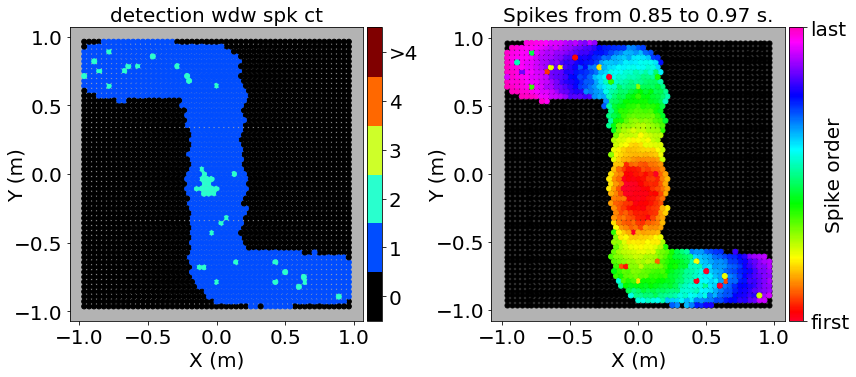

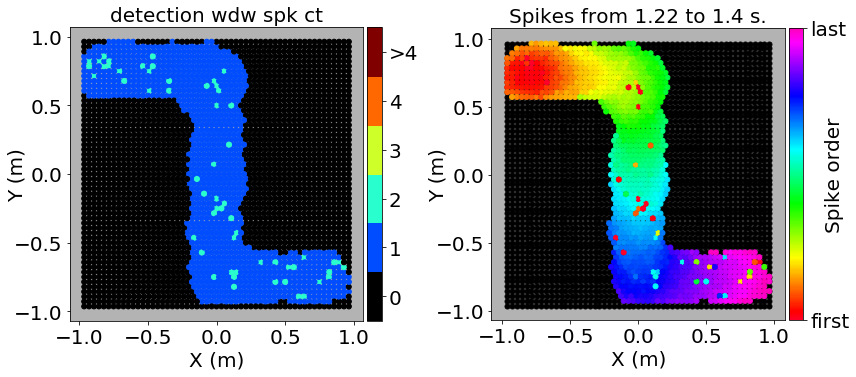

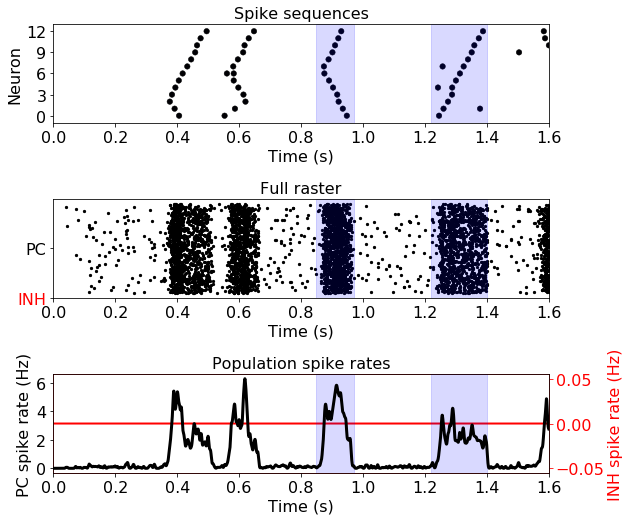

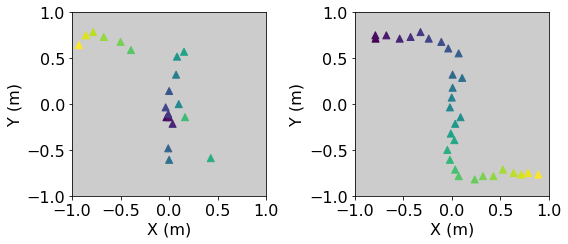

In [14]:
from replay import plot

# make plots
XYS_RASTER = [
    (-.75, .75), (-.5, .75), (-.25, .75), (0, .75),
    (0, .5), (0, .25), (0, 0), (0, -.25), (0, -.5),
    (0, -.75), (.25, -.75), (.5, -.75), (.75, -.75)
]
EPOCHS = [(.85, .97), (1.22, 1.4)]

## potentiation profile
ax, c_ax = plot.ltp_ie_profile(rslt)

## add PC labels
for ctr, (x, y) in enumerate(XYS_RASTER):
    ax.text(x, y, str(ctr), fontsize=14, horizontalalignment='center', verticalalignment='center')

## selected replay epoch spike sequences
for epoch in EPOCHS:
    fig, axs = plot.spike_seq(rslt, epoch=epoch)

## raster for selected PCs
fig, axs = plot.raster_with_pc_inh(
    rslt,
    XYS_RASTER,
    colors=np.zeros(len(XYS_RASTER)),
    cmap='inferno',
    nearest=1,
    epoch=(0, 3),
    trg_plt=[],
    fig_size=(9, 7.35),
    y_lim=(-1, 13),
    y_ticks=[0, 3, 6, 9, 12],
    smoothness=4)

for ax in axs:
    ax.set_xlim(0, 1.6)

## shade selected replay epochs
for epoch in EPOCHS:
    axs[0].axvspan(*epoch, color='b', alpha=0.15)
    axs[1].axvspan(*epoch, color='b', alpha=0.15)
    axs[2].axvspan(*epoch, color='b', alpha=0.15)
    
## plot decoded trajectories during replay epochs
axs = plt.subplots(1, len(EPOCHS), figsize=(len(EPOCHS)*4, 3.5), tight_layout=True, squeeze=False)[1][0]
for epoch, ax in zip(EPOCHS, axs):
    t, xy = analysis.decode_trj(rslt, epoch[0], epoch[1], .005, min_spks_wdw=10)
    plot.decoded_trj(ax, rslt, t, xy);

## Replay with branched trajectory

In [15]:
m_params = copy(M_PARAMS)
s_params = copy(S_PARAMS)

s_params['RNG_SEED'] = 7
s_params['TRJ'] = [(-1, 0), (1, 0), (0, 0), (0, -1), (0, 1)]

print('Running smln...')
rslt = smln.run(m_params, s_params)
print('Smln complete.')

Running smln...
Smln complete.


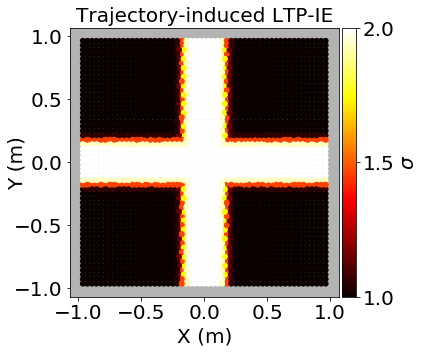

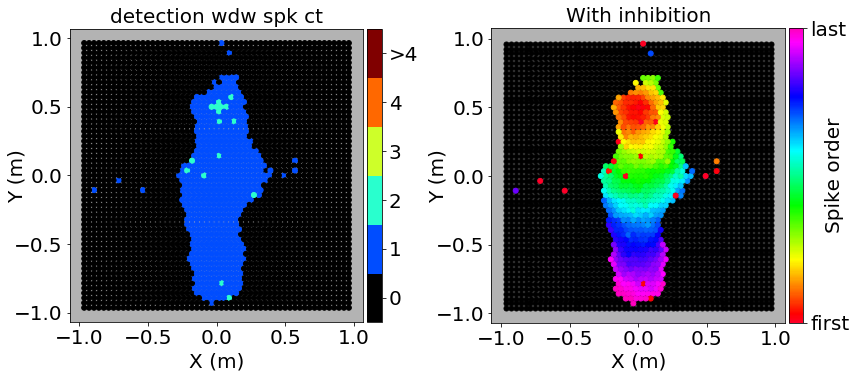

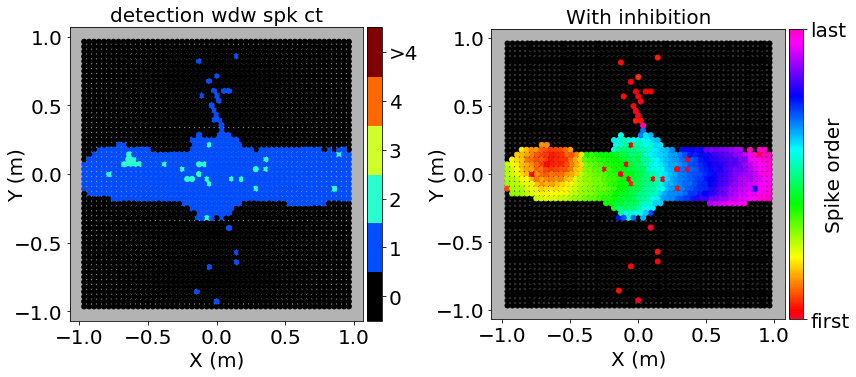

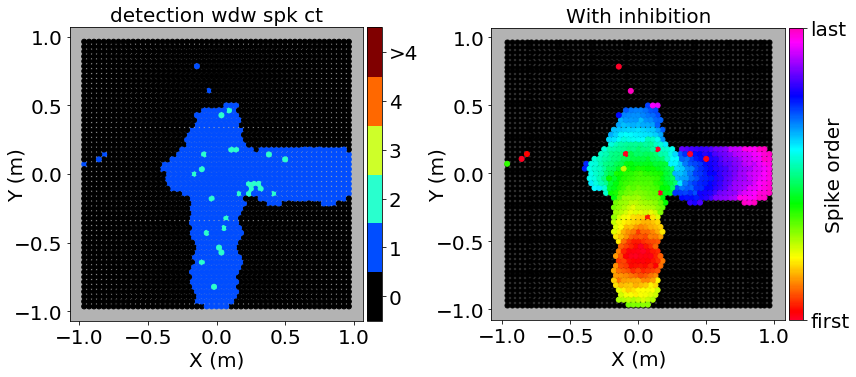

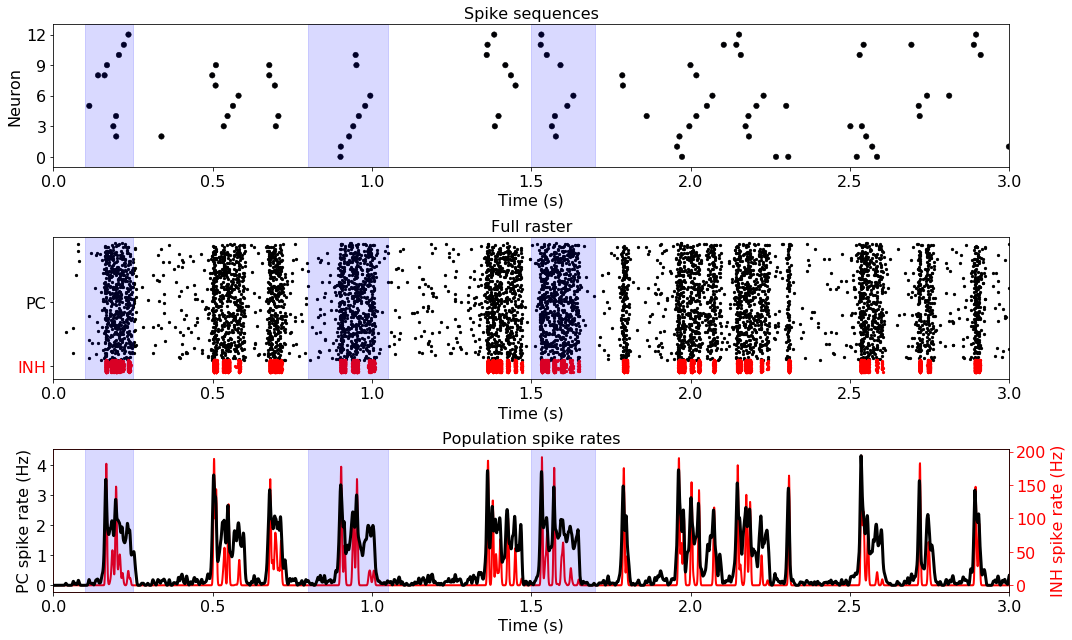

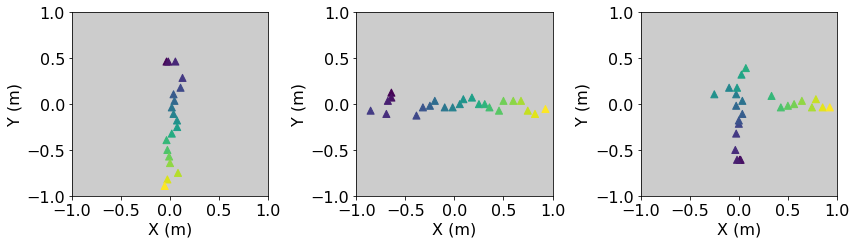

In [16]:
from replay import plot

# make plots
XYS_RASTER = [
    (-.75, 0), (-.5, 0), (-.25, 0), (0, 0), (.25, 0), (.5, 0), (.75, 0),
    (0, .75), (0, .5), (0, .25), (0, -.25), (0, -.5), (0, -.75),
]
EPOCHS = [(.1, .25), (.8, 1.05), (1.5, 1.7), ]

## potentiation profile
ax, c_ax = plot.ltp_ie_profile(rslt)

## add PC labels
#for ctr, (x, y) in enumerate(XYS_RASTER):
#    ax.text(x, y, str(ctr), fontsize=14, horizontalalignment='center', verticalalignment='center')

## selected replay epoch spike sequences
for epoch in EPOCHS:
    fig, axs = plot.spike_seq(rslt, epoch=epoch)
    axs[1].set_title('With inhibition', fontsize=20)

## raster for selected PCs
fig, axs = plot.raster_with_pc_inh(
    rslt,
    XYS_RASTER,
    colors=np.zeros(len(XYS_RASTER)),
    cmap='inferno',
    nearest=1,
    epoch=(0, 3),
    trg_plt=[],
    y_lim=(-1, 13),
    y_ticks=[0, 3, 6, 9, 12],
    smoothness=4)

## shade selected replay epochs
for epoch in EPOCHS:
    axs[0].axvspan(*epoch, color='b', alpha=0.15)
    axs[1].axvspan(*epoch, color='b', alpha=0.15)
    axs[2].axvspan(*epoch, color='b', alpha=0.15)
    
## plot decoded trajectories during replay epochs
axs = plt.subplots(1, len(EPOCHS), figsize=(len(EPOCHS)*4, 3.5), tight_layout=True, squeeze=False)[1][0]
for epoch, ax in zip(EPOCHS, axs):
    t, xy = analysis.decode_trj(rslt, epoch[0], epoch[1], .005, min_spks_wdw=10)
    plot.decoded_trj(ax, rslt, t, xy);

## Branched replay without inhibition

In [17]:
m_params = copy(M_PARAMS)
s_params = copy(S_PARAMS)
m_params['W_PC_INH'] = 0

s_params['RNG_SEED'] = 7
s_params['TRJ'] = [(-1, 0), (1, 0), (0, 0), (0, -1), (0, 1)]

print('Running smln...')
rslt = smln.run(m_params, s_params)
print('Smln complete.')

Running smln...
Smln complete.


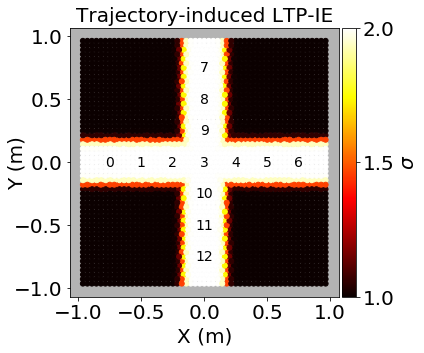

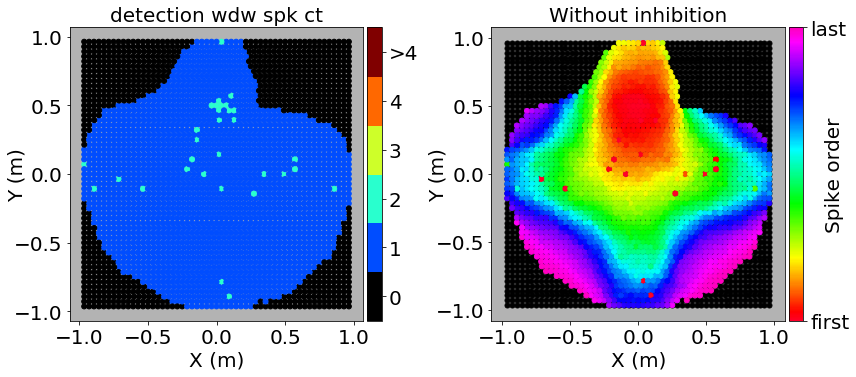

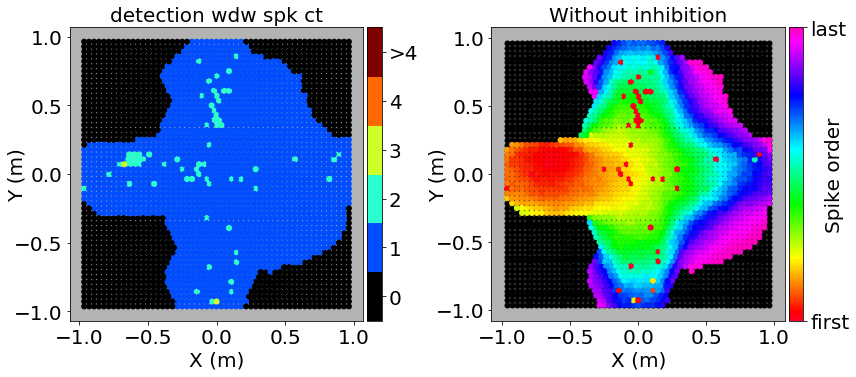

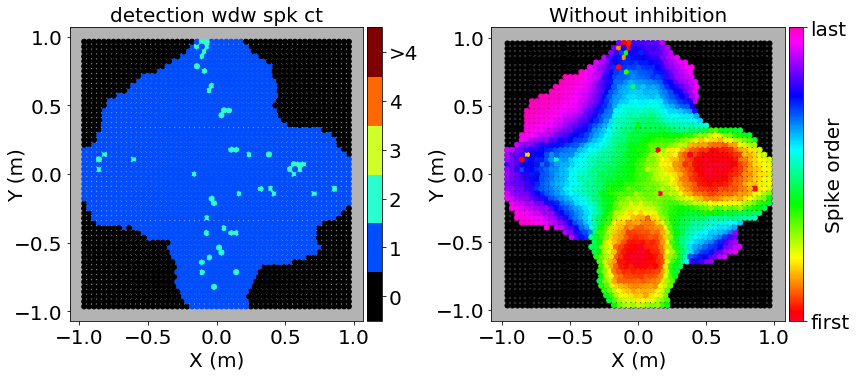

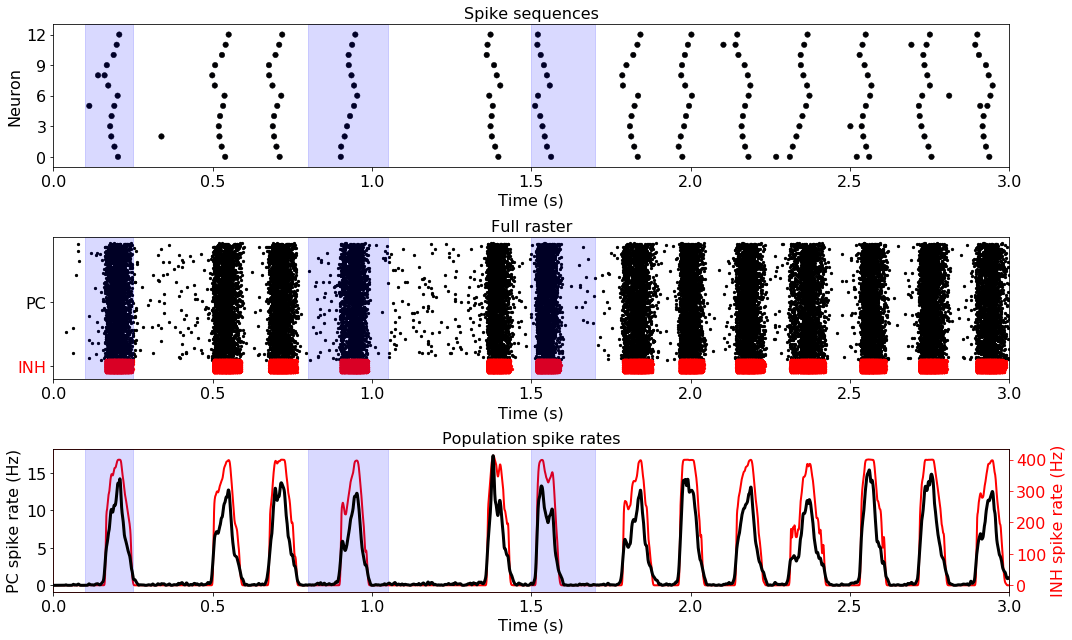

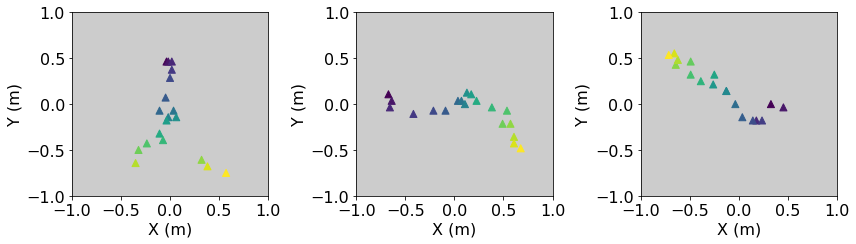

In [18]:
from replay import plot

# make plots
XYS_RASTER = [
    (-.75, 0), (-.5, 0), (-.25, 0), (0, 0), (.25, 0), (.5, 0), (.75, 0),
    (0, .75), (0, .5), (0, .25), (0, -.25), (0, -.5), (0, -.75),
]
EPOCHS = [(.1, .25), (.8, 1.05), (1.5, 1.7), ]

## potentiation profile
ax, c_ax = plot.ltp_ie_profile(rslt)

## add PC labels
for ctr, (x, y) in enumerate(XYS_RASTER):
    ax.text(x, y, str(ctr), fontsize=14, horizontalalignment='center', verticalalignment='center')

## selected replay epoch spike sequences
for epoch in EPOCHS:
    fig, axs = plot.spike_seq(rslt, epoch=epoch)
    axs[1].set_title('Without inhibition', fontsize=20)

## raster for selected PCs
fig, axs = plot.raster_with_pc_inh(
    rslt,
    XYS_RASTER,
    colors=np.zeros(len(XYS_RASTER)),
    cmap='inferno',
    nearest=1,
    epoch=(0, 3),
    trg_plt=[],
    y_lim=(-1, 13),
    y_ticks=[0, 3, 6, 9, 12],
    smoothness=4)

## shade selected replay epochs
for epoch in EPOCHS:
    axs[0].axvspan(*epoch, color='b', alpha=0.15)
    axs[1].axvspan(*epoch, color='b', alpha=0.15)
    axs[2].axvspan(*epoch, color='b', alpha=0.15)
    
## plot decoded trajectories during replay epochs
axs = plt.subplots(1, len(EPOCHS), figsize=(len(EPOCHS)*4, 3.5), tight_layout=True, squeeze=False)[1][0]
for epoch, ax in zip(EPOCHS, axs):
    t, xy = analysis.decode_trj(rslt, epoch[0], epoch[1], .005, min_spks_wdw=10)
    plot.decoded_trj(ax, rslt, t, xy);